In [1]:
import numpy as np
import scipy
import xarray as xr
import sys
from calendar import monthrange
import os
import matplotlib.pyplot as plt
import cmocean
from scipy import stats,signal


In [2]:
#%% Define directory
WRF_DIRECTORY = "/rc_scratch/misa5952/hurricanes/sst_26_skipd01/"     # This simulation has both LES (d03,d04) for at least 1 hr after spinup
# WRF_DIRECTORY = "/rc_scratch/misa5952/hurricanes/sst_26_skipd01_ndg/"
WRF_DIRECTORY = "/rc_scratch/misa5952/hurricanes/sst_26_skipd01_skipCoLES_ndg/"

WRF_DIRECTORY = "/rc_scratch/misa5952/hurricanes/sst_28_skipd01_skipCoLES_ndg/"
WRF_DIRECTORY = "/scratch/mgomez/Hurricane/idealized/test/sst_27real_skipd01_skipCoLES_ndg/"
# WRF_DIRECTORY = "/scratch/mgomez/Hurricane/idealized/test/sst_27_skipd01_skipCoLES_ndg/"


WRF_FILES = 'merged_d01.nc' 



In [3]:
#%% Extract variables from file
ds=xr.open_dataset(WRF_DIRECTORY+WRF_FILES,decode_times=False)
# Wind speed
u = ds['U']
u = np.array(u[:,0,:,:,:])
v = ds['V']
v = np.array(v[:,0,:,:,:])
w = ds['W']
w = np.array(w[:,0,:,:,:])
# De-stagger wind speed
u_des = 0.5*(u[:,:,:,0:np.shape(u)[3]-1]+u[:,:,:,1:np.shape(u)[3]])
u = 0.0
v_des = 0.5*(v[:,:,0:np.shape(v)[2]-1,:]+v[:,:,1:np.shape(v)[2],:])
v = 0.0
w_des = 0.5*(w[:,0:np.shape(w)[1]-1,:,:]+w[:,1:np.shape(w)[1],:,:])
w = 0.0
# Calculate horizontal wind speed
uv = np.sqrt(np.array(u_des)**2 + np.array(v_des)**2)
# Potential temperature
t = ds['T']
theta = np.array(t[:,0,:,:,:]) + 300
# t_skin = ds['TSK']
# t_skin = np.array(t_skin[:,0,:,:]) 
#t_skin = np.mean(np.mean(t_skin,axis=1),axis=1)
# Time
Time = ds['Times']
Time = np.array(Time)
# Domain dimensions
dx = ds.DX
n_x = dx*np.arange(0,np.shape(uv)[3])
n_y = dx*np.arange(0,np.shape(uv)[2])
# Time step
DT = ds.DT
ds.close()

# Extract height variables
height_agl = np.array([  10.597356,   32.311485,   55.092354,   78.99515 ,  104.0753  ,
        130.39023 ,  158.00024 ,  186.9681  ,  217.35979 ,  249.24423 ,
        282.6931  ,  317.78162 ,  354.5885  ,  393.19598 ,  433.68988 ,
        476.15973 ,  520.69885 ,  567.405   ,  616.37897 ,  667.7255  ,
        721.5572  ,  777.9966  ,  836.4701  ,  895.6054  ,  954.67004 ,
       1013.6671  , 1072.5979  , 1131.4629  , 1190.2615  , 1248.9944  ,
       1307.6619  , 1366.2639  , 1424.8013  , 1483.2748  , 1541.6855  ,
       1600.0352  , 1658.3245  , 1716.5544  , 1774.7263  , 1832.8411  ,
       1890.8989  , 1948.9011  , 2020.3508  , 2109.452   , 2207.3105  ,
       2314.771   , 2432.7532  , 2562.2632  , 2704.398   , 2860.3533  ,
       3031.435   , 3219.0693  , 3424.821   , 3650.4092  , 3897.7112  ,
       4168.765   , 4465.787   , 4791.201   , 5145.6133  , 5513.3467  ])
dz = height_agl[1:] - height_agl[0:-1]
height_stag = np.zeros_like(height_agl)
for i in np.arange(1,len(height_stag)):
    height_stag[i] = height_stag[i-1] + dz[i-1]
height_agl = height_agl[0:np.shape(uv)[1]]
height_stag = height_stag[0:np.shape(uv)[1]+1]


# Turbine specifications
D = 126
z_hh = 90
rated_ws = 11.4

print("done extracting variables")

done extracting variables


In [4]:
#%% Create time vector (after initialization) (ignore dates)
# Create large datetime64 array
ttime = np.arange('2000-01-01T00:00:00', '2000-01-02T00:00:00',np.shape(Time)[0], dtype='datetime64')
# Save actual times for simulation
for i_t in np.arange(0,np.shape(Time)[0]):
    a = str(Time[i_t])
    ttime[i_t] = np.datetime64(a[3:13] + str(' ')+ a[14:-2])
    # ttime[i_t] = ttime[0] + np.timedelta64(5*60,dtype='datetime64[s]')*i_t
# Save portion of temp array that actually matters
ttime = ttime[0:np.shape(Time)[0]]

print(ttime)

['2000-01-05T00:00:23' '2000-01-05T05:00:23' '2000-01-05T10:00:24'
 '2000-01-05T15:00:25' '2000-01-05T20:00:23' '2000-01-06T00:00:23'
 '2000-01-06T05:00:23' '2000-01-06T10:00:24' '2000-01-06T15:00:23'
 '2000-01-06T20:00:23' '2000-01-07T00:00:23' '2000-01-07T05:00:24'
 '2000-01-07T10:00:24' '2000-01-07T15:00:23']


In [5]:
#%% Sort arrays by time
i_sort = np.argsort(ttime)
uv = uv[i_sort,:,:,:]
u_des = u_des[i_sort,:,:,:]
v_des = v_des[i_sort,:,:,:]
w_des = w_des[i_sort,:,:,:]
theta = theta[i_sort,:,:,:]
ttime = ttime[i_sort]


In [6]:
#%% Time since initialization
t_init = np.datetime64('2000-01-05T00:00:23')

time_sinceInit = ttime - t_init
time_sinceInit = time_sinceInit.astype('timedelta64[s]')

t_since = time_sinceInit.astype('float')/3600 # [hr]


In [7]:
#%% Find hub-height
i_hh = np.argmin(np.abs(height_agl - z_hh))


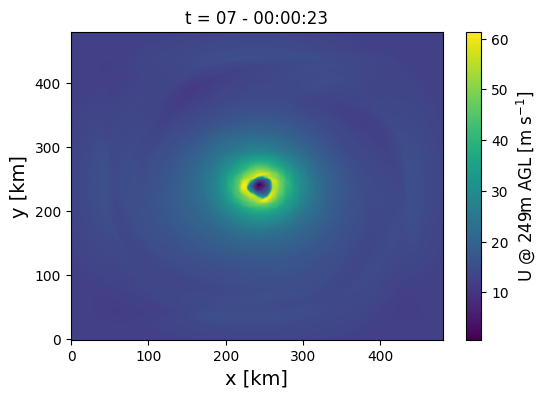

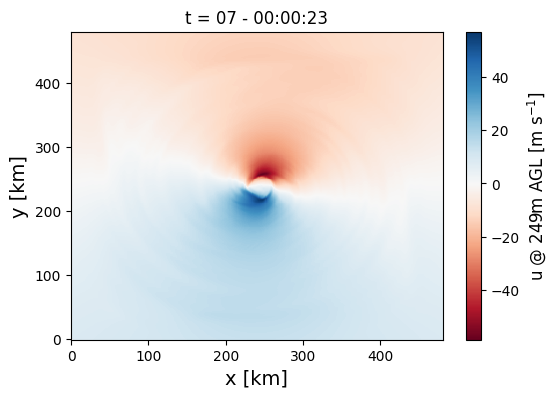

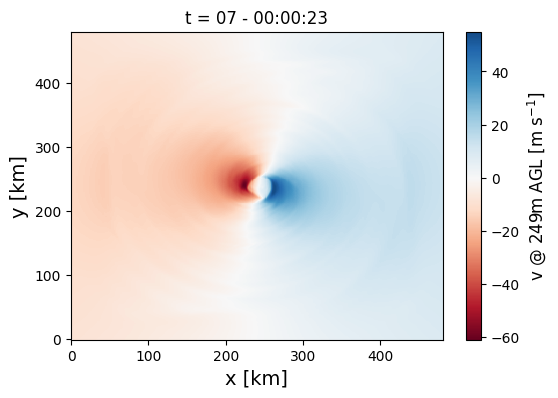

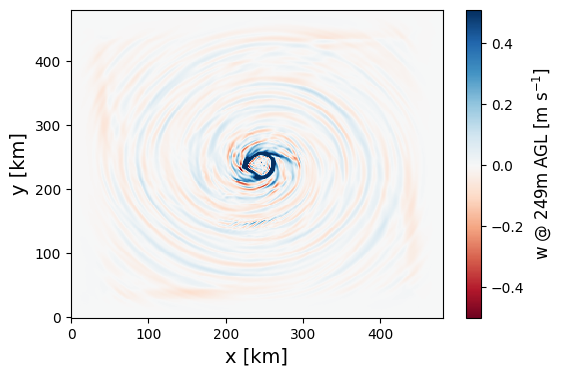

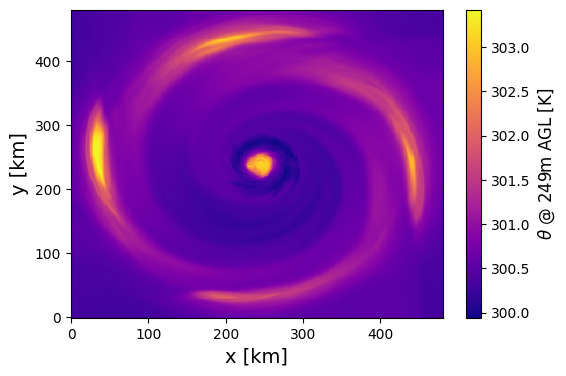

In [31]:
#%% Plot wind speed at one height
iz = np.min([9,len(height_agl)-1])#np.argmin(np.abs(height_agl - z_hh))
it = -4

# Horizontal wind speed
plt.figure(figsize=(6,4))
plt.title('t = '+str(ttime[it])[8:10]+' - '+str(ttime[it])[11:])
im1 = plt.pcolormesh(n_x/1000,n_y/1000,uv[it,iz,:,:])
cbar = plt.colorbar(im1)
cbar.set_label('U @ ' + str(int(height_agl[iz])) + 'm AGL [m s$^{-1}$]',fontsize=12)
plt.ylabel('y [km]',fontsize=14)
plt.xlabel('x [km]',fontsize=14)
#plt.scatter(n_x[4]/1000,n_y[4]/1000,color='r')
#if 'merged_d05.nc' in WRF_FILES:
#    plt.scatter(n_x[locs_ts[:,0]]/1000,n_y[locs_ts[:,1]]/1000,s=5,color='red')
#plt.xlim(143*dx/1000,(143*dx + 403*4500)/1000)
#plt.ylim(143*dx/1000,(143*dx + 403*4500)/1000)
#plt.ylim(2000,4000)
#plt.xlim(2000,4000)
plt.show()
plt.close()


# Zonal wind speed
plt.figure(figsize=(6,4))
u_des[it,iz,0,0] = 0.5
u_des[it,iz,0,1] = -0.5
newCmap = cmocean.tools.crop(plt.cm.RdBu, np.min(u_des[it,iz,:,:]), np.max(u_des[it,iz,:,:]), 0)
plt.title('t = '+str(ttime[it])[8:10]+' - '+str(ttime[it])[11:])
im1 = plt.pcolormesh(n_x/1000,n_y/1000,u_des[it,iz,:,:],cmap=newCmap)
cbar = plt.colorbar(im1)
cbar.set_label('u @ ' + str(int(height_agl[iz])) + 'm AGL [m s$^{-1}$]',fontsize=12)
plt.ylabel('y [km]',fontsize=14)
plt.xlabel('x [km]',fontsize=14)
#plt.ylim(2000,4000)
#plt.xlim(2000,4000)
plt.show()
plt.close()

# Meridional wind speed
plt.figure(figsize=(6,4))
v_des[it,iz,0,0] = 0.5
v_des[it,iz,0,1] = -0.5
newCmap = cmocean.tools.crop(plt.cm.RdBu, np.min(v_des[it,iz,:,:]), np.max(v_des[it,iz,:,:]), 0)
plt.title('t = '+str(ttime[it])[8:10]+' - '+str(ttime[it])[11:])
im1 = plt.pcolormesh(n_x/1000,n_y/1000,v_des[it,iz,:,:],cmap=newCmap)
cbar = plt.colorbar(im1)
cbar.set_label('v @ ' + str(int(height_agl[iz])) + 'm AGL [m s$^{-1}$]',fontsize=12)
plt.ylabel('y [km]',fontsize=14)
plt.xlabel('x [km]',fontsize=14)
#plt.ylim(400000/1000,600000/1000)
#plt.xlim(400000/1000,600000/1000)
plt.show()
plt.close()


# Vertical wind speed
plt.figure(figsize=(6,4))
minn = -0.5# np.min(w_des[it,iz,:,:])
maxx = 0.51 #np.max(w_des[it,iz,:,:])
newCmap = cmocean.tools.crop(plt.cm.RdBu, minn, maxx, 0)
im1 = plt.pcolormesh(n_x/1000,n_y/1000,w_des[it,iz,:,:],cmap=newCmap,vmin=minn,vmax=maxx)
cbar = plt.colorbar(im1)
cbar.set_label('w @ ' + str(int(height_agl[iz])) + 'm AGL [m s$^{-1}$]',fontsize=12)
plt.ylabel('y [km]',fontsize=14)
plt.xlabel('x [km]',fontsize=14)
#plt.ylim(400000,600000)
#plt.xlim(400000,600000)
plt.show()
plt.close()


# Potential temperature
plt.figure(figsize=(6,4))
im1 = plt.pcolormesh(n_x/1000,n_y/1000,theta[it,iz,:,:],cmap=plt.cm.plasma)
cbar = plt.colorbar(im1)
cbar.set_label(r'$\theta$ @ ' + str(int(height_agl[iz])) + 'm AGL [K]',fontsize=12)
plt.ylabel('y [km]',fontsize=14)
plt.xlabel('x [km]',fontsize=14)
#plt.ylim(400000,600000)
#plt.xlim(400000,600000)
plt.show()
plt.close()



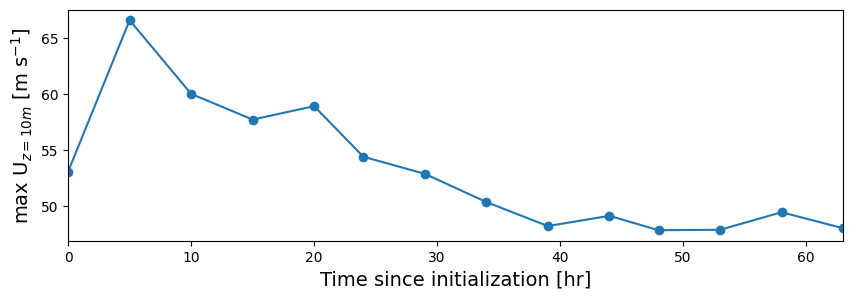

[ 0.          5.         10.00027778 15.00055556 20.         24.
 29.         34.00027778 39.         44.         48.         53.00027778
 58.00027778 63.        ]
[53.08279037 66.59888458 60.02750397 57.72826385 58.9262085  54.411026
 52.88299561 50.36507416 48.22020721 49.13446045 47.84996796 47.88871002
 49.45569992 48.02574158]


In [9]:
#%% Maximum velocity at the surface
temp_uv = np.zeros(np.shape(uv[:,0,:,:])) + uv[:,0,:,:]
temp_uv[:,0:10,:] = np.nan
temp_uv[:,-10:,:] = np.nan
temp_uv[:,:,0:10] = np.nan
temp_uv[:,:,-10:] = np.nan

max_uv_s = np.nanmax(temp_uv[:,:,:],axis=(1,2))

plt.figure(figsize=(10,3))
plt.plot(t_since[:],max_uv_s[:],'-o',zorder=0)
plt.xlabel('Time since initialization [hr]',fontsize=14)
plt.ylabel(r'max U$_{z=10m}$ [m s$^{-1}$]',fontsize=14)
plt.xlim(int(t_since[0]),t_since[-1])
# plt.legend()
plt.show()
plt.close()


# print(np.nanmean(temp_uv[-4]))
# print(ttime[-12])

print(t_since)
print(max_uv_s)



ix_max = 172; iy_max = 173
ix_max = 147; iy_max = 165
ix_max = 154; iy_max = 147
ix_max = 150; iy_max = 168
ix_max = 176; iy_max = 156
ix_max = 156; iy_max = 148
ix_max = 146; iy_max = 167
ix_max = 173; iy_max = 160
ix_max = 156; iy_max = 144
ix_max = 159; iy_max = 144
ix_max = 149; iy_max = 160
ix_max = 158; iy_max = 154
ix_max = 148; iy_max = 166
ix_max = 151; iy_max = 160


(0.0, 282.6931)

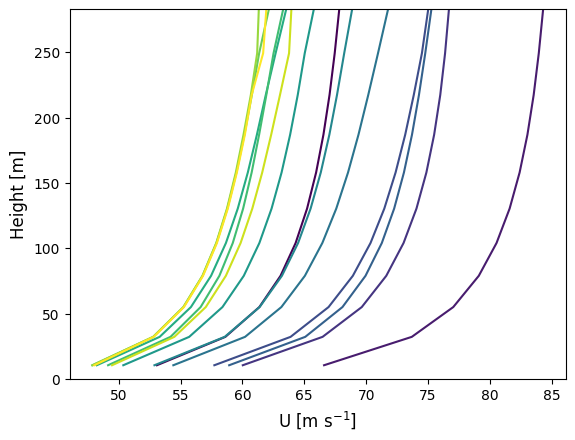

In [10]:
#%% Vertical profile of maximum wind speed
x_grid,y_grid = np.meshgrid(n_x,n_y)

z_max = height_agl[-1]
col = plt.cm.viridis(np.linspace(0,1,np.shape(theta)[0]))

plt.figure()
for it in np.arange(np.shape(theta)[0]):
    temp_uv = np.zeros(np.shape(uv[it,0,:,:])) + uv[it,0,:,:]
    temp_uv[0:10,:] = 0
    temp_uv[-10:,:] = 0
    temp_uv[:,0:10] = 0
    temp_uv[:,-10:] = 0
    uv_flat = np.reshape(temp_uv,[len(n_x)*len(n_y)])
    nx_flat = np.reshape(x_grid[:,:],[len(n_x)*len(n_y)])
    ny_flat = np.reshape(y_grid[:,:],[len(n_x)*len(n_y)])
    max_ws_ref = np.argmax(uv_flat)
    ix_max = np.argmin(np.abs(nx_flat[max_ws_ref] - n_x))
    iy_max = np.argmin(np.abs(ny_flat[max_ws_ref] - n_y))
    print('ix_max = '+str(ix_max) + '; iy_max = '+str(iy_max))
    plt.plot(uv[it,:,iy_max,ix_max],height_agl,color=col[it],label='t = '+str(ttime[it])[8:])
plt.xlabel(r'U [m s$^{-1}$]',fontsize=12)
plt.ylabel(r'Height [m]',fontsize=12)
plt.ylim(0,z_max)
# plt.legend()


In [11]:
#%% Find center of hurricane based on minimum wind speed
center = np.zeros([len(ttime),2]) + np.nan # [x,y]

X_grid,Y_grid = np.meshgrid(n_x,n_y)
X_grid = X_grid.flatten()
Y_grid = Y_grid.flatten()

for iitt in np.arange(np.shape(uv)[0]):
    
    temp_uv = np.zeros(np.shape(uv[iitt,0,:,:])) + uv[iitt,0,:,:]
    temp_uv[0:10,:] = np.nan
    temp_uv[-10:,:] = np.nan
    temp_uv[:,0:10] = np.nan
    temp_uv[:,-10:] = np.nan
    uv_flat = temp_uv.flatten() #uv[-1,0,:,:].flatten()
    uv_flat[np.isnan(uv_flat)] = 0
    max_ws_ref = np.argmax(uv_flat)
    
    if 'd01' in WRF_FILES:
#         if iitt==0:
        lim_low_x = np.mean(n_x) - 0.1*n_x[-1]
        lim_low_y = np.mean(n_x) - 0.1*n_x[-1]
        lim_high_x = np.mean(n_x) + 0.1*n_x[-1]
        lim_high_y = np.mean(n_x) + 0.1*n_x[-1]
        if iitt>0:
#             lim_low_x = center[iitt-1,0] - 0.1*n_x[-1]
#             lim_low_y = center[iitt-1,1] - 0.1*n_x[-1]
#             lim_high_x = center[iitt-1,0] + 0.1*n_x[-1]
#             lim_high_y = center[iitt-1,1] + 0.1*n_x[-1]
            lim_low_x = X_grid[max_ws_ref] - 0.1*n_x[-1]
            lim_low_y = Y_grid[max_ws_ref] - 0.1*n_x[-1]
            lim_high_x = X_grid[max_ws_ref] + 0.1*n_x[-1] 
            lim_high_y = Y_grid[max_ws_ref] + 0.1*n_x[-1]
        
    # Create small meshgrid
    small_x,small_y = np.meshgrid(n_x[(n_x<lim_high_x)&(n_x>lim_low_x)],n_y[(n_y<lim_high_y)&(n_y>lim_low_y)])
    flat_smallX = small_x.flatten()
    flat_smallY = small_y.flatten()

    # Crop array
    temp_uv_1 = uv[iitt,0,(n_y<lim_high_y)&(n_y>lim_low_y),:]
    temp_uv_2 = temp_uv_1[:,(n_x<lim_high_x)&(n_x>lim_low_x)]
    # Flatten array
    temp_uv_flat = temp_uv_2.flatten()
    # Find location of minimum
    if np.any(temp_uv_flat)==True:
        i_min = np.argmin(temp_uv_flat)
        # Save location of minimum
        center[iitt,0] = flat_smallX[i_min]
        center[iitt,1] = flat_smallY[i_min]
    else:
        # Save location of minimum
        center[iitt,0] = np.mean(n_x)
        center[iitt,1] = np.mean(n_y)
print(center/dx)

[[160. 161.]
 [160. 160.]
 [162. 161.]
 [162. 162.]
 [162. 163.]
 [158. 164.]
 [159. 163.]
 [159. 160.]
 [160. 160.]
 [159. 160.]
 [162. 161.]
 [162. 164.]
 [159. 161.]
 [162. 161.]]


In [12]:
#%% Get geometrical center using velocity contours
slow_winds = [5,7,9]
slow_winds = [5,10,15]
geo_center2 = np.zeros([len(ttime),len(slow_winds),2])

dyn_center = center
for iitt in np.arange(len(ttime)):
    ## Limits on what to plot
    lim_low_x = dyn_center[iitt,0] - 0.3*np.mean(n_x)
    lim_low_y = dyn_center[iitt,1] - 0.3*np.mean(n_y)
    lim_high_x = dyn_center[iitt,0] + 0.3*np.mean(n_x)
    lim_high_y = dyn_center[iitt,1] + 0.3*np.mean(n_y)
    
    
    # Get contours for a set of slow wind speeds close to the hurricane center
    small_x = n_x[(n_x>lim_low_x) & (n_x<lim_high_x)]
    small_y = n_y[(n_y>lim_low_y) & (n_y<lim_high_y)]
    small_uv = uv[iitt,iz,(n_y>lim_low_y) & (n_y<lim_high_y),:]
    small_uv = small_uv[:,(n_x>lim_low_x) & (n_x<lim_high_x)]
    cs = plt.contour(small_x/1000,small_y/1000,small_uv, slow_winds)
    paths = cs.collections
    plt.close()
    
#    plt.figure()
#    plt.contourf(small_x/1000,small_y/1000,small_uv)
#    plt.contour(small_x/1000,small_y/1000,small_uv, slow_winds,cmap=plt.cm.binary)
#    plt.show()
    
    # Get vertices of contours for each wind speed
    for i_ws in np.arange(len(slow_winds)):
        allP = paths[i_ws].get_paths()
        # Find longest path
        longest = 0
        len_longest = 0
        if len(allP)>0:
            for i_p in np.arange(len(allP)):
                if len(allP[i_p]) > len_longest:
                    longest = i_p
                    len_longest = len(allP[i_p])
            path = allP[longest]
            verts = path.vertices
            x_contour = verts[:,0]
            y_contour = verts[:,1]
            geo_center2[iitt,i_ws,0] = np.mean(x_contour)*1000
            geo_center2[iitt,i_ws,1] = np.mean(y_contour)*1000
        

In [13]:
#%% Choose which method for finding the center
meth_cent = 'oth'
if meth_cent=='geo':
    temp_cent = np.zeros_like(geo_center2[:,1,:]) + geo_center2[:,2,:] + 0.0
else:
    temp_cent = np.zeros_like(center) + center + 0.0


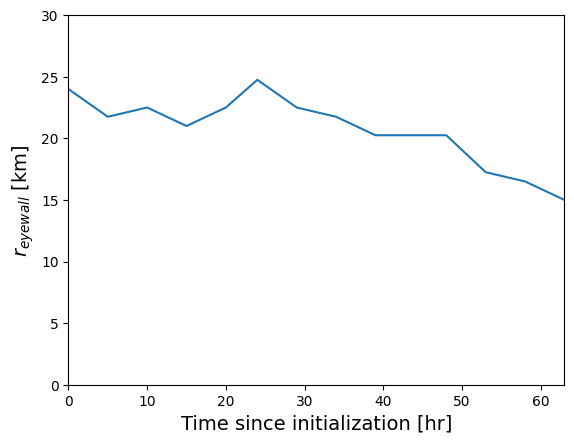

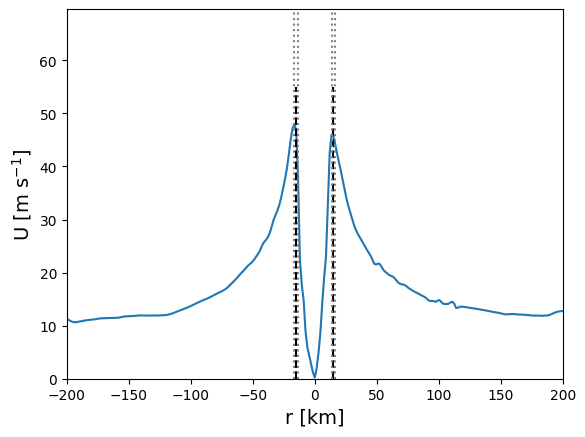

[24000. 21750. 22500. 21000. 22500. 24750. 22500. 21750. 20250. 20250.
 20250. 17250. 16500. 15000.]


In [14]:
#%% Find radius of eyewall in hurricane
r_eye = np.zeros(np.shape(ttime))
r1 = np.zeros(np.shape(ttime))
r2 = np.zeros(np.shape(ttime))

r_x = (n_x - temp_cent[-1,0])/1000


# Find radius of eyewall for each time
for ii in np.arange(len(ttime)):
    temp_uv = np.zeros(np.shape(uv[ii,0,:,:])) + uv[ii,0,:,:]
    temp_uv[0:10,:] = 0
    temp_uv[-10:,:] = 0
    temp_uv[:,0:10] = 0
    temp_uv[:,-10:] = 0
    
    i_r_max1 = np.argmax(temp_uv[int(temp_cent[ii,1]/dx),int(temp_cent[ii,0]/dx):])
    i_r_max2 = np.argmax(temp_uv[int(temp_cent[ii,1]/dx),0:int(temp_cent[ii,0]/dx)])
    r1[ii] = np.abs(n_x[int(temp_cent[ii,0]/dx):][i_r_max1] - temp_cent[ii,0])
    r2[ii] = np.abs(n_x[0:int(temp_cent[ii,0]/dx)][i_r_max2] - temp_cent[ii,0])
    r_eye[ii] = 0.5*(r1[ii] + r2[ii])

# Temporal evolution of hurricane eyewall
plt.figure()
plt.plot(t_since,r_eye/1000)
plt.xlabel('Time since initialization [hr]',fontsize=14)
plt.ylabel(r'$r_{eyewall}$ [km]',fontsize=14)
plt.xlim(t_since[0],t_since[-1])
plt.ylim(0,30)
plt.show()
plt.close() 

# Plot of wind speed
it = -1
plt.figure()
plt.plot((n_x-center[it,0])/1000,uv[it,0,int(temp_cent[it,1]/dx),:])
plt.plot(np.array([r_eye[it],r_eye[it]])/1000,[0,50+5],'--k')
plt.plot(np.array([-1*r_eye[it],-1*r_eye[it]])/1000,[0,50+5],'--k')

plt.plot(np.array([-1*r1[it],-1*r1[it]])/1000,[0,np.max(uv[:,0,int(temp_cent[it,1]/dx),:])+5],':',color='grey')
plt.plot(np.array([-1*r2[it],-1*r2[it]])/1000,[0,np.max(uv[:,0,int(temp_cent[it,1]/dx),:])+5],':',color='grey')

plt.plot(np.array([r1[it],r1[it]])/1000,[0,np.max(uv[:,0,int(temp_cent[it,1]/dx),:])+5],':',color='grey')
plt.plot(np.array([r2[it],r2[it]])/1000,[0,np.max(uv[:,0,int(temp_cent[it,1]/dx),:])+5],':',color='grey')

plt.xlim(np.min((n_x - center[it,0])/1000),np.max((n_x - center[it,0])/1000))
plt.xlim(np.max([-200,r_x[0]]),np.min([200,r_x[-1]]))
plt.ylim(0,np.max(uv[:,0,int(temp_cent[it,1]/dx),:])+5)
plt.xlabel('r [km]',fontsize=14)
plt.ylabel('U [m s$^{-1}$]',fontsize=14)
plt.show()
plt.close()  

print(r_eye)


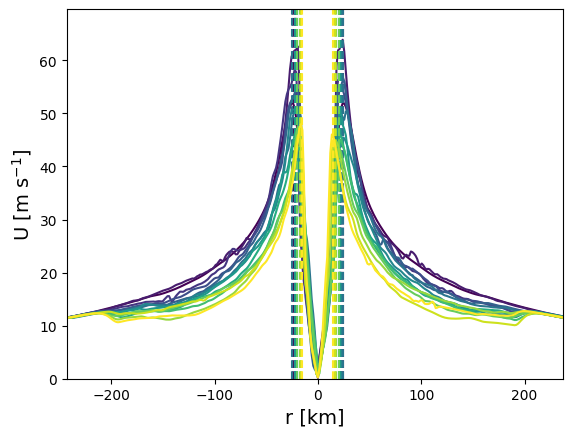

In [15]:
#%% Evolution of radius of maximum winds
cols = plt.cm.viridis(np.linspace(0,1,len(ttime)))
plt.figure()
for it in np.arange(len(ttime)):
    plt.plot((n_x-center[it,0])/1000,uv[it,0,int(temp_cent[it,1]/dx),:],color=cols[it])
    plt.plot(np.array([r_eye[it],r_eye[it]])/1000,[0,100],'--',color=cols[it])
    plt.plot(np.array([-1*r_eye[it],-1*r_eye[it]])/1000,[0,100],'--',color=cols[it])

plt.xlim(np.min((n_x - temp_cent[it,0])/1000),np.max((n_x - temp_cent[it,0])/1000))
plt.xlim(np.max([-350,r_x[0]]),np.min([350,r_x[-1]]))
plt.ylim(0,np.max(uv[:,0,int(temp_cent[it,1]/dx),:])+5)
plt.xlabel('r [km]',fontsize=14)
plt.ylabel('U [m s$^{-1}$]',fontsize=14)
plt.show()
plt.close() 


In [16]:
#%% Crop all 3D fields to a shared reference frame that is centered on the center of the hurricane
# Maximum distance from center of the hurricane
max_dist_fromCent = 200000

# Find the maximum radial distance from the hurricane's center that is shared for all times
for it in np.arange(len(ttime)):
    # Distance from hurricane cetner to domain boundaries
    dd_x = np.min([center[it,0] - n_x[0],n_x[-1] - center[it,0]])
    dd_y = np.min([center[it,1] - n_y[0],n_y[-1] - center[it,1]])
    # Minimum distance to domain boundaries
    dd = np.min([dd_x,dd_y])
    if dd<max_dist_fromCent:
        max_dist_fromCent = dd
# Round down
temp = np.floor(max_dist_fromCent/1000)
max_dist_fromCent = temp*1000

# Initialize array
u_r = np.zeros([len(ttime),len(height_agl),int(2*max_dist_fromCent/dx),int(2*max_dist_fromCent/dx)]) + np.nan
v_r = np.zeros([len(ttime),len(height_agl),int(2*max_dist_fromCent/dx),int(2*max_dist_fromCent/dx)]) + np.nan
w_r = np.zeros([len(ttime),len(height_agl),int(2*max_dist_fromCent/dx),int(2*max_dist_fromCent/dx)]) + np.nan
theta_r = np.zeros([len(ttime),len(height_agl),int(2*max_dist_fromCent/dx),int(2*max_dist_fromCent/dx)]) + np.nan
uv_r = np.zeros([len(ttime),len(height_agl),int(2*max_dist_fromCent/dx),int(2*max_dist_fromCent/dx)]) + np.nan

for iitt in np.arange(len(ttime)):
    # Geometrical center
    geo_cent = [center[iitt,0],center[iitt,1]]
    ix_c = int(geo_cent[0]/dx)
    iy_c = int(geo_cent[1]/dx)
    # Save portion of hurricane
    if iitt==0:
        dim1 = np.shape(u_r[iitt,:,:,:])[-1]
        dim2 = np.shape(u_des[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx),ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)])[-1]
    if dim1==dim2:
        u_r[iitt,:,:,:] = u_des[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx),ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)]
        v_r[iitt,:,:,:] = v_des[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx),ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)]
        w_r[iitt,:,:,:] = w_des[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx),ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)]
        theta_r[iitt,:,:,:] = theta[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx),ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)]
        uv_r[iitt,:,:,:] = uv[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx),ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)]
    else:
        u_r[iitt,:,:,:] = u_des[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx)+1,ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)+1]
        v_r[iitt,:,:,:] = v_des[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx)+1,ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)+1]
        w_r[iitt,:,:,:] = w_des[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx)+1,ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)+1]
        theta_r[iitt,:,:,:] = theta[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx)+1,ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)+1]
        uv_r[iitt,:,:,:] = uv[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx)+1,ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)+1]
    
    
# Release memory
# u = 0.0
# v = 0.0
# w = 0.0
# uv = 0.0
# theta = 0.0

# # Temporal average of centered velocity fields
# mean_u_r = np.nanmean(u_r,axis=0)
# mean_v_r = np.nanmean(v_r,axis=0)
# mean_w_r = np.nanmean(w_r,axis=0)
# mean_theta_r = np.nanmean(theta_r,axis=0)
mean_uv_r = np.nanmean(uv_r,axis=0)

# New distance arrays
n_x_r = np.arange(np.shape(mean_uv_r)[2])*dx
n_y_r = np.arange(np.shape(mean_uv_r)[1])*dx
temp_gridx,temp_gridy = np.meshgrid(n_x_r,n_y_r)
temp_uv = mean_uv_r[0,:,:].flatten()
temp_gridx = temp_gridx.flatten()
temp_gridy = temp_gridy.flatten()
n_x_r = n_x_r - temp_gridx[np.argmin(temp_uv)]
n_y_r = n_y_r - temp_gridy[np.argmin(temp_uv)]

temp_uv = 0.0
temp_gridx = 0.0
temp_gridy = 0.0

In [17]:
#%% Crop 3D fields to make them centered in a rectangle (x-y)
min_x = np.min(np.abs(np.array([n_x_r[0],n_x_r[-1]])))
min_y = np.min(np.abs(np.array([n_y_r[0],n_y_r[-1]])))

u_r = u_r[:,:,(n_y_r>-1*min_y)&(n_y_r<min_y),:]
u_r = u_r[:,:,:,(n_x_r>-1*min_x)&(n_x_r<min_x)]

v_r = v_r[:,:,(n_y_r>-1*min_y)&(n_y_r<min_y),:]
v_r = v_r[:,:,:,(n_x_r>-1*min_x)&(n_x_r<min_x)]

w_r = w_r[:,:,(n_y_r>-1*min_y)&(n_y_r<min_y),:]
w_r = w_r[:,:,:,(n_x_r>-1*min_x)&(n_x_r<min_x)]

theta_r = theta_r[:,:,(n_y_r>-1*min_y)&(n_y_r<min_y),:]
theta_r = theta_r[:,:,:,(n_x_r>-1*min_x)&(n_x_r<min_x)]

uv_r = uv_r[:,:,(n_y_r>-1*min_y)&(n_y_r<min_y),:]
uv_r = uv_r[:,:,:,(n_x_r>-1*min_x)&(n_x_r<min_x)]

n_x_r = n_x_r[(n_x_r>-1*min_x)&(n_x_r<min_x)]
n_y_r = n_y_r[(n_y_r>-1*min_y)&(n_y_r<min_y)]


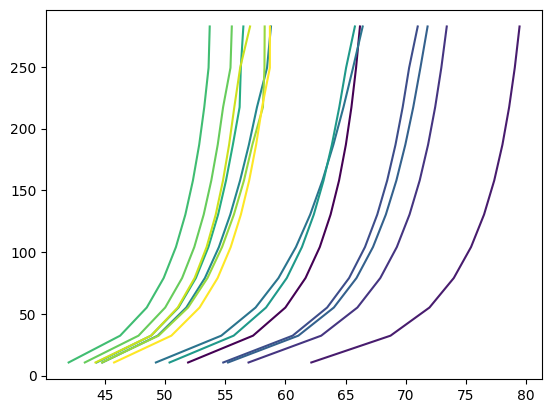

In [18]:
#%% Temporal evolution of velocity profiles at one location
r_hat = 1

plt.figure()
for i in np.arange(len(ttime)):
    ir = np.argmin(np.abs(n_x_r - r_eye[i]*r_hat))
    plt.plot(uv_r[i,:,int(0.5*len(n_y_r)),ir],height_agl,color=cols[i])

In [24]:
#%% Calculate temporal average after spinup
t0 = 6#7 #np.argmin(np.abs(t_since - 34))
t1 = t0+1 #np.argmin(np.abs(t_since - 40))
t0 = np.argmin(np.abs(t_since - 39))
t1 = np.argmin(np.abs(t_since - 51))

# Temporal average of centered velocity fields
mean_u_r = np.nanmean(u_r[t0:t1,:,:,:],axis=0)
mean_v_r = np.nanmean(v_r[t0:t1,:,:,:],axis=0)
mean_w_r = np.nanmean(w_r[t0:t1,:,:,:],axis=0)
mean_theta_r = np.nanmean(theta_r[t0:t1,:,:,:],axis=0)
mean_uv_r = np.nanmean(uv_r[t0:t1,:,:,:],axis=0)

print(ttime[t0:t1])
# print(ttime[t1])

['2000-01-06T15:00:23' '2000-01-06T20:00:23' '2000-01-07T00:00:23']


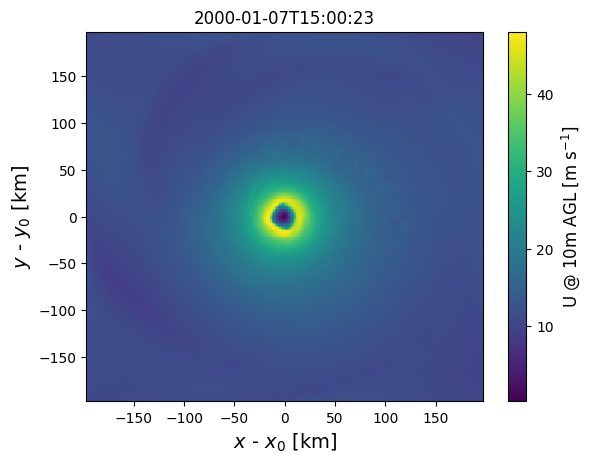

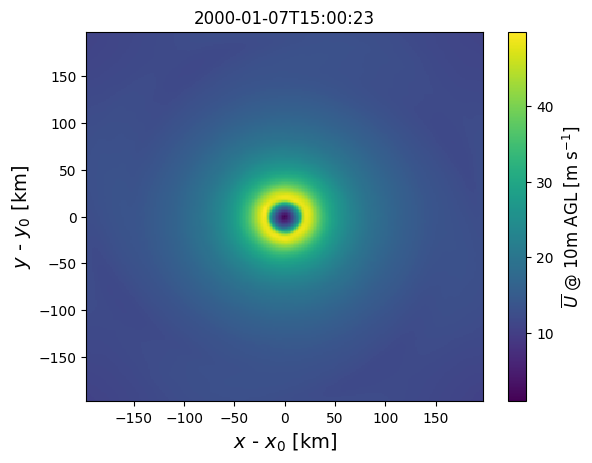

In [25]:
# Velocity contours at one height
iz = 0
it = len(ttime)-1

plt.figure()
plt.title(ttime[it])
im1 = plt.pcolormesh(n_x_r/1000,n_y_r/1000,uv_r[it,iz,:,:])
plt.xlabel(r'$x$ - $x_0$ [km]',fontsize=14)
plt.ylabel(r'$y$ - $y_0$ [km]',fontsize=14)
cbar = plt.colorbar(im1)
cbar.set_label(r'U @ ' + str(int(height_agl[iz])) + 'm AGL [m s$^{-1}$]',fontsize=12)
plt.show()
plt.close()  


plt.figure()
plt.title(ttime[it])
im1 = plt.pcolormesh(n_x_r/1000,n_y_r/1000,np.nanmean(uv_r[:,iz,:,:],axis=0))
plt.xlabel(r'$x$ - $x_0$ [km]',fontsize=14)
plt.ylabel(r'$y$ - $y_0$ [km]',fontsize=14)
cbar = plt.colorbar(im1)
cbar.set_label(r'$\overline{U}$ @ ' + str(int(height_agl[iz])) + 'm AGL [m s$^{-1}$]',fontsize=12)
plt.show()
plt.close()  


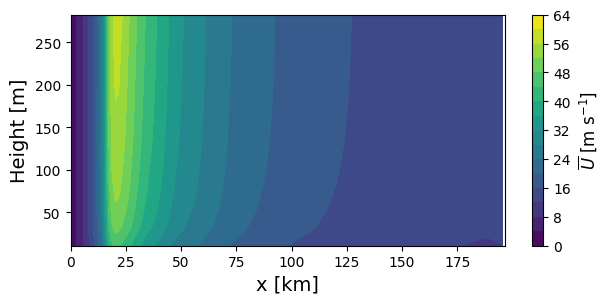

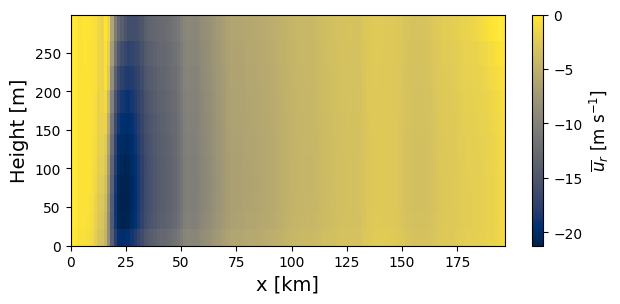

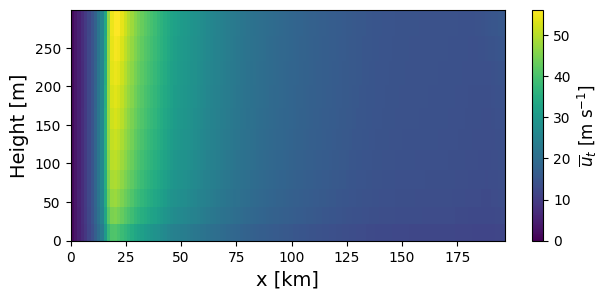

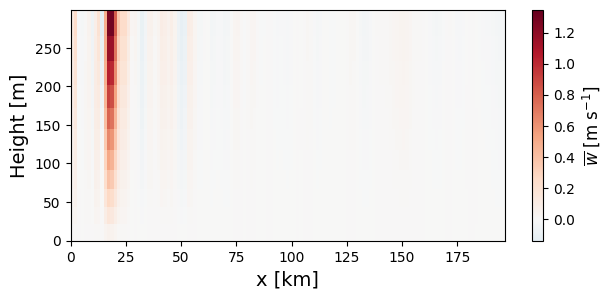

In [26]:
#%% Slice of velocity fields
# Horizontal velocity field
plt.figure(figsize=(7,3))
im1 = plt.contourf((n_x_r-0.5*dx)/1000,height_agl,mean_uv_r[:,int(0.5*len(n_y_r)),:],levels=15) 
plt.xlabel('x [km]',fontsize=14)
plt.ylabel('Height [m]',fontsize=14)
plt.xlim(0,n_x_r[-1]/1000)
cbar = plt.colorbar(im1)
cbar.set_label(r'$\overline{U}$ [m s$^{-1}$]',fontsize=12)
plt.show()
plt.close()  

# Radial velocity field
plt.figure(figsize=(7,3))
minn = np.min(mean_u_r[:,int(0.5*len(n_y_r)),:])
maxx = np.max(mean_u_r[:,int(0.5*len(n_y_r)),:])
newCmap = cmocean.tools.crop(plt.cm.RdBu, minn, maxx, 0)
im1 = plt.pcolormesh((n_x_r-0.5*dx)/1000,height_agl,mean_u_r[:,int(0.5*len(n_y_r)),:],vmax=0,cmap=plt.cm.cividis) 
plt.xlabel('x [km]',fontsize=14)
plt.ylabel('Height [m]',fontsize=14)
plt.xlim(0,n_x_r[-1]/1000)
cbar = plt.colorbar(im1)
cbar.set_label(r'$\overline{u}_r$ [m s$^{-1}$]',fontsize=12)
plt.show()
plt.close() 

# Tangential velocity field
plt.figure(figsize=(7,3))
# newCmap = cmocean.tools.crop(plt.cm.RdBu, np.min(mean_v_r[:,int(0.5*len(n_y_r)),:]), np.max(mean_v_r[:,int(0.5*len(n_y_r)),:]), 0)
im1 = plt.pcolormesh((n_x_r-0.5*dx)/1000,height_agl,mean_v_r[:,int(0.5*len(n_y_r)),:],cmap=plt.cm.viridis,vmin=0) 
plt.xlabel('x [km]',fontsize=14)
plt.ylabel('Height [m]',fontsize=14)
plt.xlim(0,n_x_r[-1]/1000)
cbar = plt.colorbar(im1)
cbar.set_label(r'$\overline{u}_t$ [m s$^{-1}$]',fontsize=12)
plt.show()
plt.close() 

# Vertical velocity field
plt.figure(figsize=(7,3))
minn = np.min(mean_w_r[:,int(0.5*len(n_y_r)),:])
maxx = np.max(mean_w_r[:,int(0.5*len(n_y_r)),:])
newCmap = cmocean.tools.crop(plt.cm.RdBu_r, minn, maxx, 0)
im1 = plt.pcolormesh((n_x_r-0.5*dx)/1000,height_agl,mean_w_r[:,int(0.5*len(n_y_r)),:],cmap=newCmap,vmin=minn,vmax=maxx) 
plt.xlabel('x [km]',fontsize=14)
plt.ylabel('Height [m]',fontsize=14)
plt.xlim(0,n_x_r[-1]/1000)
cbar = plt.colorbar(im1)
cbar.set_label(r'$\overline{w}$ [m s$^{-1}$]',fontsize=12)
plt.show()
plt.close()  

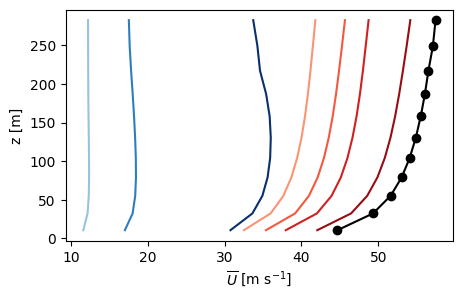

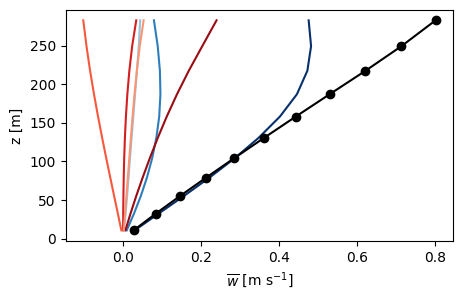

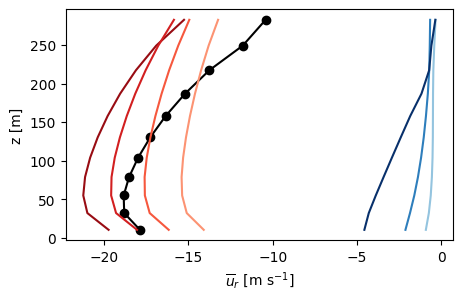

In [27]:
#%% Radial evolution of time-averaged velocity profiles for times of interest
r_max = np.abs(n_x_r[int(0.5*len(n_x_r)) + np.argmax(mean_uv_r[0,int(0.5*len(n_y_r)),int(0.5*len(n_x_r)):])])
r_hats = np.arange(0.4,2,np.max([0.2*r_max,int(dx)])/r_max)

cols_r_less_than_R = plt.cm.Blues(np.linspace(0.4,1,len(r_hats[r_hats<1])))
cols_r_greater_than_R = plt.cm.Reds_r(np.linspace(0.1,0.8,len(r_hats[r_hats>1])))

closest_to_R = np.argmin(np.abs(r_hats - 1)) #+ 1

# Horizontal velocity
c_less = 0
c_greater = 0
plt.figure(figsize=(5,3))
for i in np.arange(len(r_hats)):
    ir = np.argmin(np.abs(n_x_r - r_max*r_hats[i]))
    if i==closest_to_R:
        plt.plot(mean_uv_r[:,int(0.5*len(n_y_r)),ir],height_agl,'-o',color='black')
    elif r_hats[i]<1:
        plt.plot(mean_uv_r[:,int(0.5*len(n_y_r)),ir],height_agl,color=cols_r_less_than_R[c_less])
        c_less = c_less + 1
    else:# r_hats[i]>1:
        plt.plot(mean_uv_r[:,int(0.5*len(n_y_r)),ir],height_agl,color=cols_r_greater_than_R[c_greater])
        c_greater = c_greater + 1
plt.xlabel(r"$\overline{U}$ [m s$^{-1}$]")
plt.ylabel("z [m]")
plt.show()
plt.close()

# Vertical velocity
c_less = 0
c_greater = 0
plt.figure(figsize=(5,3))
for i in np.arange(len(r_hats)):
    ir = np.argmin(np.abs(n_x_r - r_max*r_hats[i]))
    if i==closest_to_R:
        plt.plot(mean_w_r[:,int(0.5*len(n_y_r)),ir],height_agl,'-o',color='black')
    elif r_hats[i]<1:
        plt.plot(mean_w_r[:,int(0.5*len(n_y_r)),ir],height_agl,color=cols_r_less_than_R[c_less])
        c_less = c_less + 1
    else:# r_hats[i]>1:
        plt.plot(mean_w_r[:,int(0.5*len(n_y_r)),ir],height_agl,color=cols_r_greater_than_R[c_greater])
        c_greater = c_greater + 1
plt.xlabel(r"$\overline{w}$ [m s$^{-1}$]")
plt.ylabel("z [m]")
plt.show()
plt.close()

# Radial velocity
c_less = 0
c_greater = 0
plt.figure(figsize=(5,3))
for i in np.arange(len(r_hats)):
    ir = np.argmin(np.abs(n_x_r - r_max*r_hats[i]))
    if i==closest_to_R:
        plt.plot(mean_u_r[:,int(0.5*len(n_y_r)),ir],height_agl,'-o',color='black')
    elif r_hats[i]<1:
        plt.plot(mean_u_r[:,int(0.5*len(n_y_r)),ir],height_agl,color=cols_r_less_than_R[c_less])
        c_less = c_less + 1
    else:# r_hats[i]>1:
        plt.plot(mean_u_r[:,int(0.5*len(n_y_r)),ir],height_agl,color=cols_r_greater_than_R[c_greater])
        c_greater = c_greater + 1
plt.xlabel(r"$\overline{u}_r$ [m s$^{-1}$]")
plt.ylabel("z [m]")
plt.show()
plt.close()

In [28]:
center/dx

array([[160., 161.],
       [160., 160.],
       [162., 161.],
       [162., 162.],
       [162., 163.],
       [158., 164.],
       [159., 163.],
       [159., 160.],
       [160., 160.],
       [159., 160.],
       [162., 161.],
       [162., 164.],
       [159., 161.],
       [162., 161.]])

In [37]:
ttime[np.argmin(np.abs(t_since-40))]
center[np.argmin(np.abs(t_since-40)),:]/dx

array([160., 160.])

In [38]:
np.argmin(np.abs(t_since-40))

8